<a href="https://colab.research.google.com/github/vahidzad/vahidzad-When-Computer-vision-meets-Electromagnetics/blob/main/Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
tf.test.gpu_device_name()
!nvidia-smi

Thu Nov 19 01:15:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |    227MiB / 15079MiB |      7%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks/Vision/'

Cross_sections	 Features-2d.txt  Final_Models	Vision.ipynb
Features-1d.txt  Features-3d.txt  Raw_indecies


In [ ]:
Index_address = '/content/drive/My Drive/Colab Notebooks/Vision/Raw_indecies/'
images_dir = '/content/drive/My Drive/Colab Notebooks/Vision/Cross_sections'
Result1D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-1d.txt'
Result2D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-2d.txt'
Result3D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-3d.txt'

In [ ]:
# Saving Cross section images in the drive
'''
for i in range (2386,2427):
  Index_address_temp = Index_address + str(i) + ".txt"
  data = pd.read_csv(Index_address_temp, sep='\t', header = None,engine='python')
  ax = sns.heatmap(data, cmap="Paired", xticklabels=False, yticklabels=False,cbar = False , vmin=0, vmax=6)
  figure = ax.get_figure()
  plt.savefig(f"{images_dir}/%d.jpg"%(i))
  del data
'''

'\nfor i in range (2386,2427):\n  Index_address_temp = Index_address + str(i) + ".txt"\n  data = pd.read_csv(Index_address_temp, sep=\'\t\', header = None,engine=\'python\')\n  ax = sns.heatmap(data, cmap="Paired", xticklabels=False, yticklabels=False,cbar = False , vmin=0, vmax=6)\n  figure = ax.get_figure()\n  plt.savefig(f"{images_dir}/%d.jpg"%(i))\n  del data\n'

In [ ]:
Result1D = pd.read_csv(Result1D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Result2D_adress, sep='\t', header = None,engine='python')
Result3D = pd.read_csv(Result3D_adress, sep='\t', header = None,engine='python')
Results = pd.concat([Result1D, Result2D,Result3D])
Results = Results.drop([0],axis=1)  # get rid of the number of layers for now
Results_classification = Results.drop([8,9,10],axis=1)

In [ ]:
Results_classification.tail()

,1,2,3,4,5,6,7
1495,0,1,0,0,1,0,1
1496,0,1,0,0,1,0,1
1497,0,1,0,0,1,0,1
1498,0,1,0,0,1,0,1
1499,0,1,0,0,1,0,1


In [ ]:
Results_classification.shape

(2426, 7)

In [ ]:
#Loading the images
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

Features = []

for i in tqdm(range(Results.shape[0])):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  Features.append(img)
Features = np.array(Features)

100%|██████████| 2426/2426 [00:08<00:00, 283.39it/s]


In [ ]:
Features.shape

(2426, 288, 432, 3)

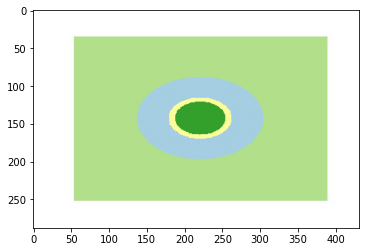

In [ ]:
plt.imshow(Features[1380])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, Results_classification, random_state = 0, test_size = 0.2)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
LaekyRelu = tf.keras.layers.LeakyReLU(alpha=0.2)

model = Sequential()
model.add(Conv2D(50, (3,3), activation='relu', input_shape = X_train[0].shape))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(35, (3,3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(30, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(15, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(7, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 286, 430, 50)      1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 143, 215, 50)      0         
_________________________________________________________________
dropout (Dropout)            (None, 143, 215, 50)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 141, 213, 35)      15785     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 70, 106, 35)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 106, 35)       0         
_________________________________________________________________
flatten (Flatten)            (None, 259700)            0

In [ ]:
tf.keras.backend.clear_session()
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
history = model.fit(X_train, y_train, validation_split=0.2,batch_size=128, epochs=500,callbacks=callback)

Epoch 1/500
13/13 [==============================] - 7s 509ms/step - loss: 1.7636 - accuracy: 0.2796 - val_loss: 0.6924 - val_accuracy: 0.0026
Epoch 2/500
13/13 [==============================] - 6s 465ms/step - loss: 0.6902 - accuracy: 0.3041 - val_loss: 0.6910 - val_accuracy: 0.0670
Epoch 3/500
13/13 [==============================] - 6s 467ms/step - loss: 0.6826 - accuracy: 0.4034 - val_loss: 0.6841 - val_accuracy: 0.4485
Epoch 4/500
13/13 [==============================] - 6s 480ms/step - loss: 0.6678 - accuracy: 0.3750 - val_loss: 0.6659 - val_accuracy: 0.3763
Epoch 5/500
13/13 [==============================] - 6s 470ms/step - loss: 0.6542 - accuracy: 0.3466 - val_loss: 0.6515 - val_accuracy: 0.3737
Epoch 6/500
13/13 [==============================] - 6s 478ms/step - loss: 0.6404 - accuracy: 0.3956 - val_loss: 0.6429 - val_accuracy: 0.4072
Epoch 7/500
13/13 [==============================] - 6s 469ms/step - loss: 0.6250 - accuracy: 0.4671 - val_loss: 0.6123 - val_accuracy: 0.5696

#best model so far = 
16 - 32 - 32 with tanh and SGD (defult) (3,3)

16 - 32 - 16 with tanh and SGD (defult) (3,3)

16 - 32 - 16 with tanh and SGD (0.001) (3,3) without batch normalizaton graphs looks good

20 - 30 - 20 - 10 with tanh and SGD (0.001) (3,3) without batch normalizaton graphs looks good

30-25-25-15 with Relu and Adam (0.001) without batch normalizaton graphs looks good


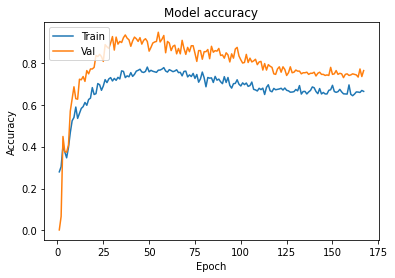

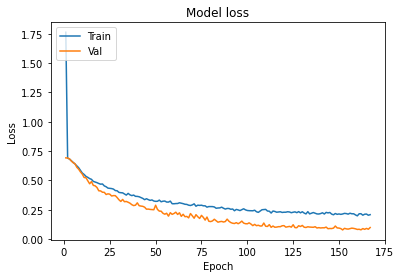

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, len(history.history['loss']))

In [ ]:
X_train[0].shape

(288, 432, 3)

In [ ]:
X_test[0].shape

(288, 432, 3)

In [ ]:
i = 5
print(model.predict(X_test[i].reshape(1,288,432,3)))
print(y_train.iloc[i,:])

[[0.03171892 0.9664589  0.9856279  0.00787232 0.11716323 0.09817322
  0.3561813 ]]
1    0
2    1
3    1
4    0
5    0
6    1
7    0
Name: 802, dtype: int64


In [ ]:
#saving the model
#model.save('Vision_classifier1.h5')